In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [2]:
def plot_samples(x, y, n_samples=5, cmap='tab20'):
    
    idxs = np.arange(len(x))[:n_samples]
    plt.figure(figsize=(n_samples * 3, 6))
    for i, idx in enumerate(idxs):
        img = x[idx]
        mask = y[idx]

        # Image
        plt.subplot(2, n_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.ylabel("Image", fontsize=12)

        # Mask
        plt.subplot(2, n_samples, i+1+n_samples)
        plt.imshow(mask, cmap=cmap, vmin=0, vmax=np.max(y))
        plt.axis('off')
        if i == 0:
            plt.ylabel("Mask", fontsize=12)

    plt.tight_layout()
    plt.show()

In [3]:
def upscale(images, masks, target_size=(256, 256)):

    x_upscale = []
    y_upscale = []

    for i in range(images.shape[0]):
        image = images[i]
        mask = masks[i]

        # Ensure mask is single-channel int (class IDs)
        if mask.ndim == 3 and mask.shape[-1] > 1:
            mask = np.argmax(mask, axis=-1)  # from one-hot to class IDs
        mask = mask.astype(np.uint8)

        # Resize image (bicubic)
        upscale_image = cv2.resize(
            image,
            target_size,
            interpolation=cv2.INTER_CUBIC
        )
        upscale_image = np.clip(upscale_image, 0.0, 1.0)
        
        # Resize mask (nearest neighbor for class IDs)
        upscale_mask = cv2.resize(
            mask,
            target_size,
            interpolation=cv2.INTER_NEAREST
        )

        x_upscale.append(upscale_image)
        y_upscale.append(upscale_mask)

    return np.array(x_upscale), np.array(y_upscale)

In [4]:
def class_aware_crop(x_imgs, y_imgs, crop_size, rare_classes, pixel_thresh, max_crops):
    """Return crops from images with enough rare-class pixels."""
    crops_x, crops_y = [], []
    for img, label in zip(x_imgs, y_imgs):
        if np.sum(np.isin(label, rare_classes)) < pixel_thresh:
            continue
        coords = np.argwhere(np.isin(label, rare_classes))
        for _ in range(max_crops):
            y_c, x_c = coords[random.randint(0, len(coords) - 1)]
            xs = max(0, min(x_c - crop_size // 2, img.shape[1] - crop_size))
            ys = max(0, min(y_c - crop_size // 2, img.shape[0] - crop_size))
            crop_x, crop_y = img[ys:ys+crop_size, xs:xs+crop_size, :], label[ys:ys+crop_size, xs:xs+crop_size]
            crops_x.append(crop_x)
            crops_y.append(crop_y)
    return np.array(crops_x), np.array(crops_y)

In [5]:
def horizontal_flip(x_train, y_train, p=0.5):
    x_flipped, y_flipped = [], []
    for img, mask in zip(x_train, y_train):
        if np.random.rand() < p:
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        x_flipped.append(img)
        y_flipped.append(mask)
    
    return np.array(x_flipped), np.array(y_flipped)

x_train shape: (2975, 64, 64, 3)
y_train shape: (2975, 64, 64)
Range: [0.051, 0.996]
Range: [0, 19]


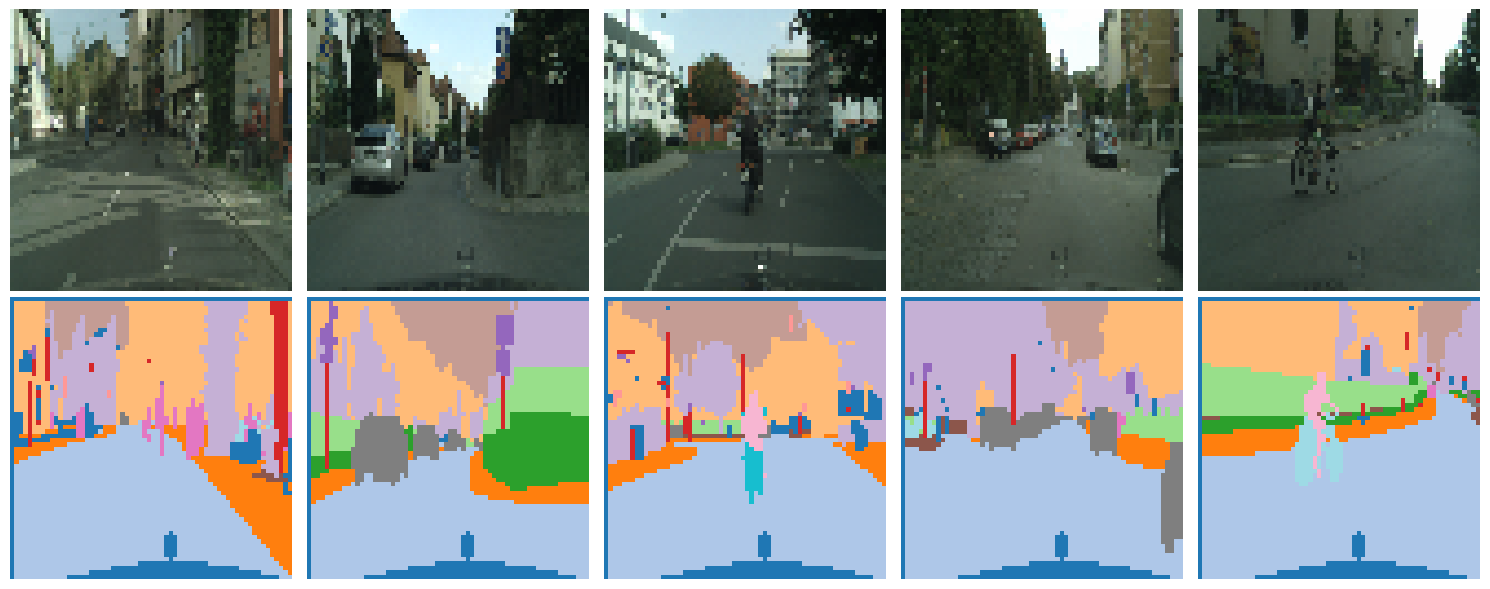

x_train shape: (2975, 128, 128, 3)
y_train shape: (2975, 128, 128)


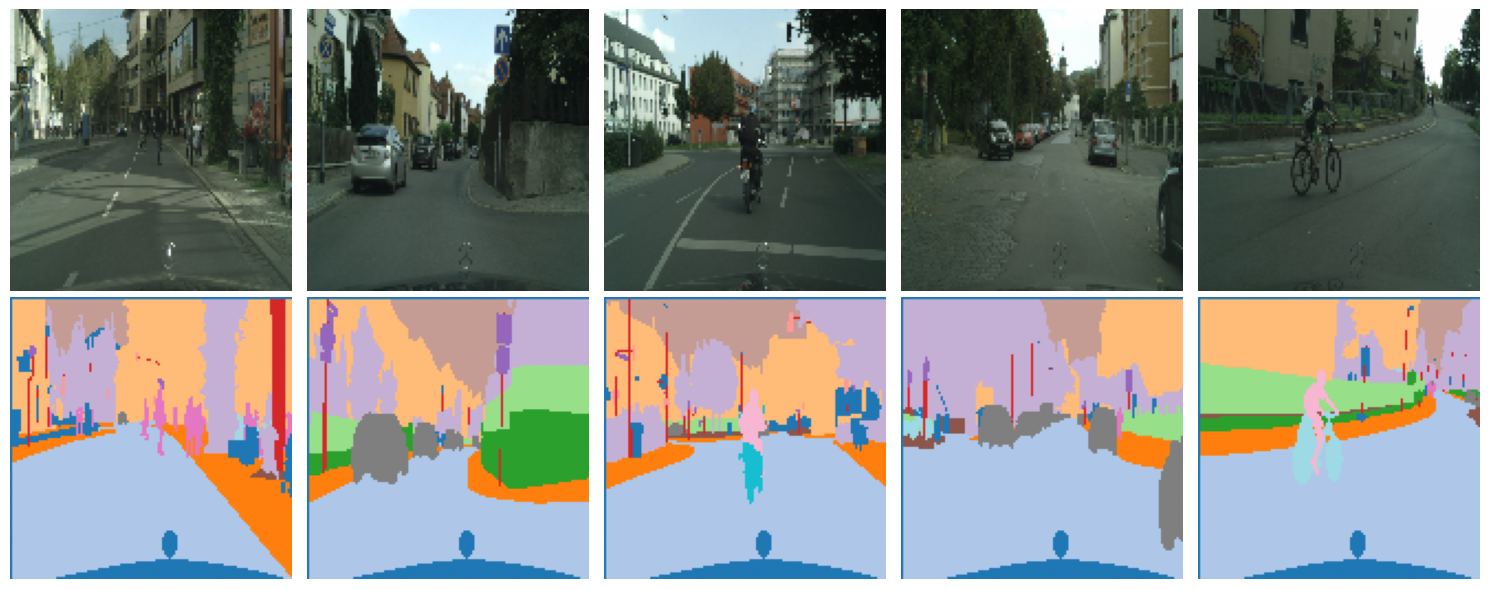

In [6]:
n_classes = 20

# original 64x64 dataset
train_data = np.load(f"cityscapes_train_size(64 64).npz")
x_train = train_data['x_train']
y_train = train_data['y_train']
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Range: [{x_train[0].min():.3f}, {x_train[0].max():.3f}]")
print(f"Range: [{y_train[0].min()}, {y_train[0].max()}]")
plot_samples(x_train, y_train, n_samples=5)

# 128x128 dataset
train_data_large = np.load(f"cityscapes_train_size(128 128).npz")
x_train_large = train_data_large['x_train']
y_train_large = train_data_large['y_train']
print(f"x_train shape: {x_train_large.shape}")
print(f"y_train shape: {y_train_large.shape}")
plot_samples(x_train_large, y_train_large, n_samples=5)

x_train_upscale shape: (2975, 192, 192, 3)
y_train_upscale shape: (2975, 192, 192)


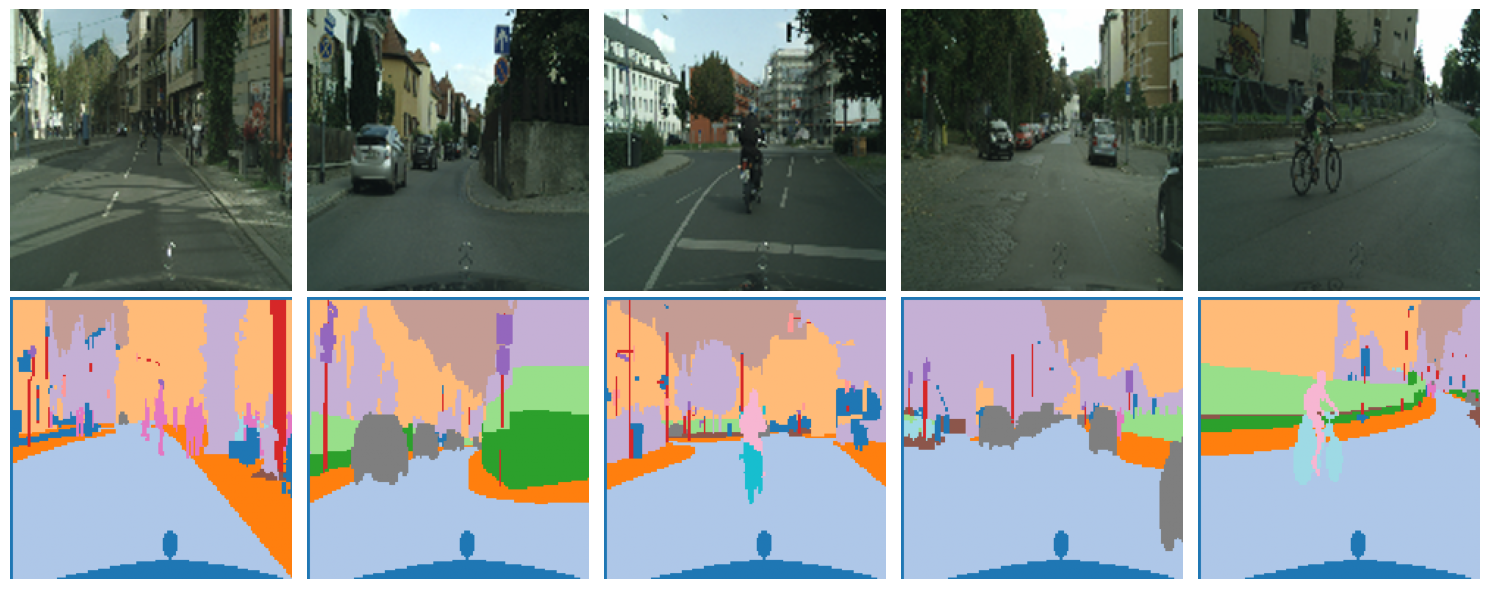

In [7]:
# upscale 192x192 dataset
x_train_upscale, y_train_upscale = upscale(x_train_large, y_train_large, target_size=(192, 192))
print(f"x_train_upscale shape: {x_train_upscale.shape}")
print(f"y_train_upscale shape: {y_train_upscale.shape}")
plot_samples(x_train_upscale, y_train_upscale, n_samples=5)

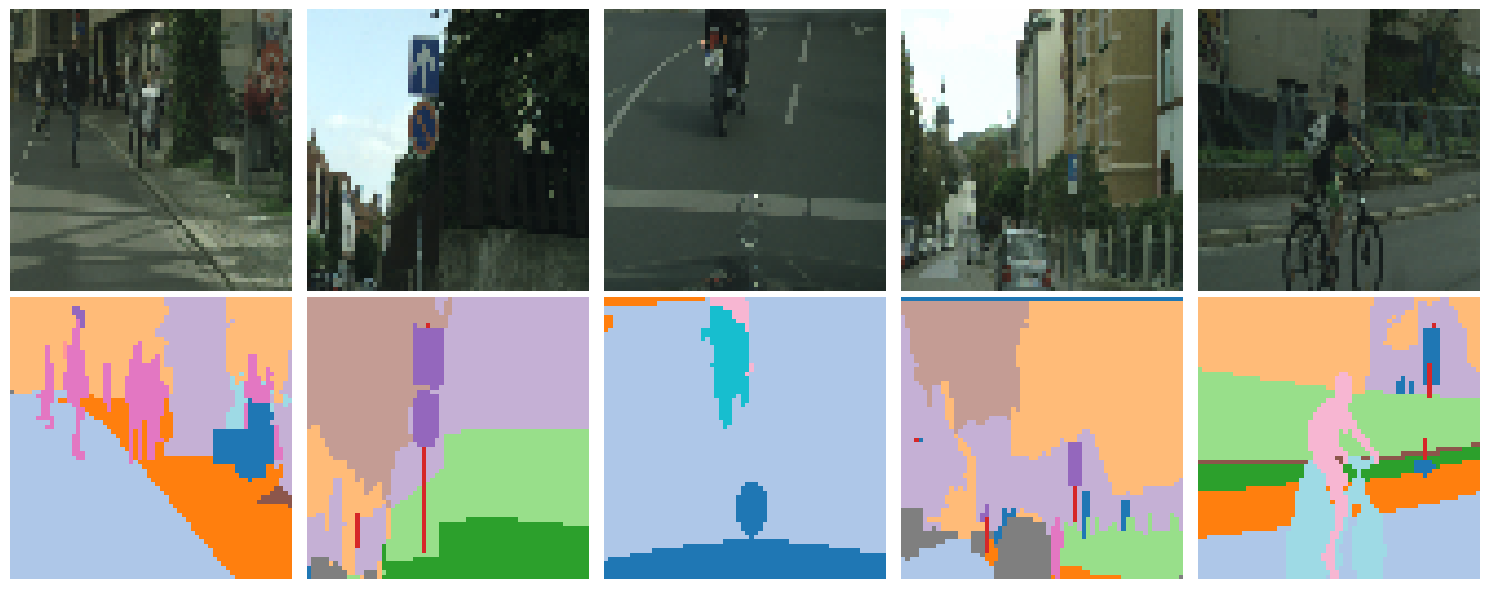

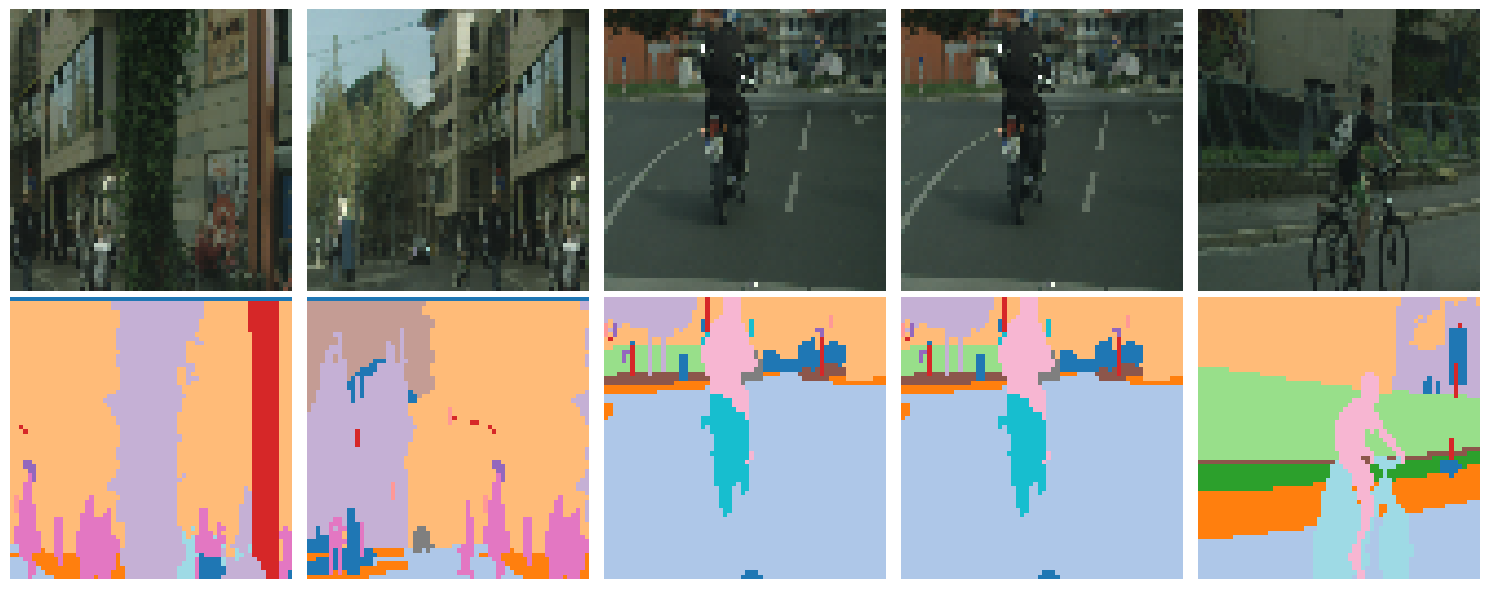

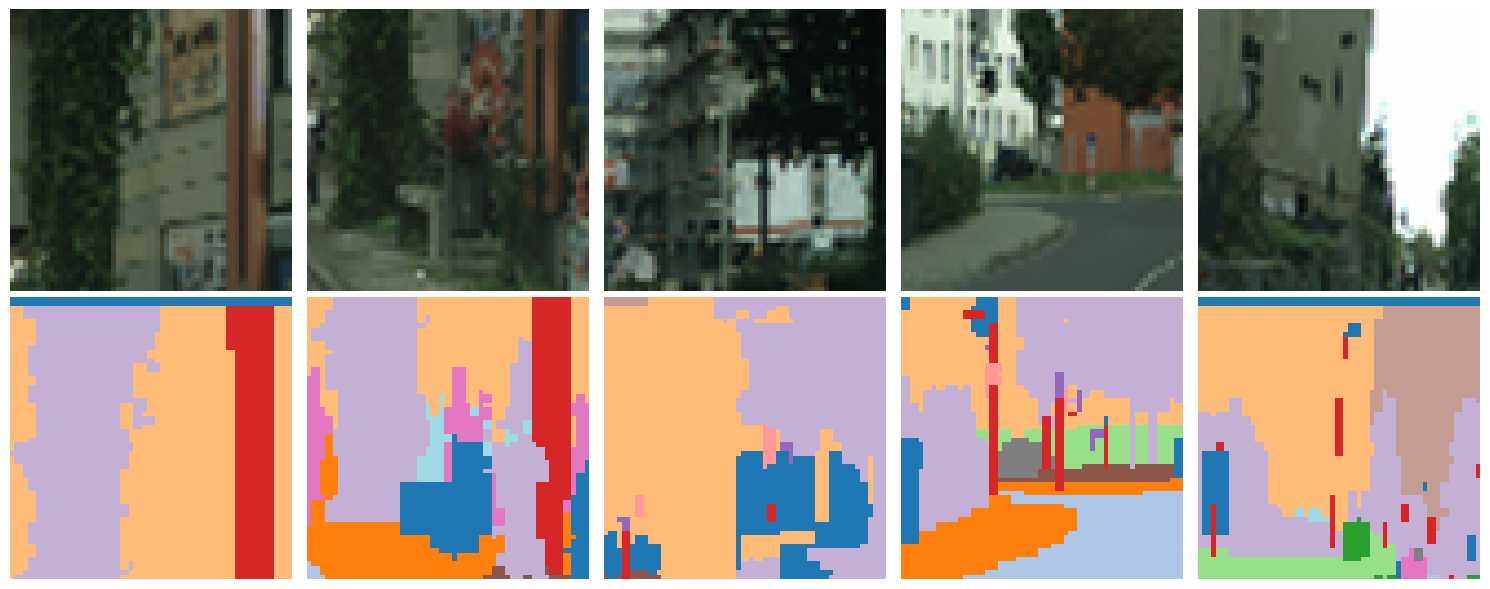

In [8]:
high_classes = [ 1,  3,  9, 10, 11]                     # original 64x64 dataset
mid_classes  = [ 0,  2,  4,  5, 12, 14]                 # crop from 128x128 dataset
low_classes  = [ 6,  7,  8, 13, 15, 16, 17, 18, 19]     # crop from 128x128 and 192x192 dataset

# mid class crops (128x128)
x_mid_crop, y_mid_crop = class_aware_crop(
    x_train_large, y_train_large,
    crop_size=64, rare_classes=mid_classes,
    pixel_thresh=1800, max_crops=1
)
plot_samples(x_mid_crop, y_mid_crop, n_samples=5)

# low class crops (128x128 and 192x192)
x_low_crop, y_low_crop = class_aware_crop(
    x_train_large, y_train_large,
    crop_size=64, rare_classes=low_classes,
    pixel_thresh=600, max_crops=2
)
plot_samples(x_low_crop, y_low_crop, n_samples=5)

x_low_crop_upscale, y_low_crop_upscale = class_aware_crop(
    x_train_upscale, y_train_upscale,
    crop_size=64, rare_classes=low_classes,
    pixel_thresh=1200, max_crops=2
)
plot_samples(x_low_crop_upscale, y_low_crop_upscale, n_samples=5)

In [9]:
print(f"Image size original 64x64 dataset: {x_train.shape}")
print(f"Image size mid class 128x128 crops: {x_mid_crop.shape}")
print(f"Image size low class 128x128 crops: {x_low_crop.shape}")
print(f"Image size low class 192x192 crops: {x_low_crop_upscale.shape}")

Image size original 64x64 dataset: (2975, 64, 64, 3)
Image size mid class 128x128 crops: (2922, 64, 64, 3)
Image size low class 128x128 crops: (1488, 64, 64, 3)
Image size low class 192x192 crops: (1780, 64, 64, 3)


In [10]:
x_train = np.concatenate([x_train, x_mid_crop, x_low_crop, x_low_crop_upscale], axis = 0)
y_train = np.concatenate([y_train, y_mid_crop, y_low_crop, y_low_crop_upscale], axis = 0)
print(f"Before flip size: {x_train.shape}, {y_train.shape}")

x_train_flip, y_train_flip = horizontal_flip(x_train, y_train, p=1)

x_train = np.concatenate([x_train, x_train_flip], axis = 0)
y_train = np.concatenate([y_train, y_train_flip], axis = 0)
print(f"Final training size: {x_train.shape}, {y_train.shape}")

Before flip size: (9165, 64, 64, 3), (9165, 64, 64)
Final training size: (18330, 64, 64, 3), (18330, 64, 64)


# build qkeras Model

In [11]:
from qkeras import *
from tensorflow.keras.layers import Input, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def unet(input_shape=(None, None, 3), n_classes=20):
    
    activation       = 'quantized_relu(6)'
    kernel_quantizer = 'quantized_bits(8,2,alpha=1)'
    bias_quantizer   = 'quantized_bits(8,2,alpha=1)'

    def residual_block(x, filters):

        shortcut = x # input fo shortcut connection

        # projection layer 1x1 convolution for channel mismatch
        shortcut = QConv2D(
            filters=filters,
            kernel_size=1,
            padding='same',
            kernel_quantizer=kernel_quantizer,
            bias_quantizer=bias_quantizer,
            use_bias=False
        )(shortcut)

        # first convolutional layer
        x = QConv2DBatchnorm(
            filters=filters,
            kernel_size=3,
            padding='same',
            kernel_quantizer=kernel_quantizer,
            bias_quantizer=bias_quantizer,
            use_bias=True
        )(x)
        x = QActivation(activation)(x)

        # second convolutional layer
        x = QConv2DBatchnorm(
            filters=filters,
            kernel_size=3,
            padding='same',
            kernel_quantizer=kernel_quantizer,
            bias_quantizer=bias_quantizer,
            use_bias=True
        )(x)
        x = QActivation(activation)(x)
        x = Add()([shortcut, x]) # shortcut to output of convolutions
        return x

    def down_block(x, filters):
        x = QConv2DBatchnorm(
            filters=filters,
            kernel_size=3,
            strides=2, # Downsample by stride
            padding='same',
            kernel_quantizer=kernel_quantizer,
            bias_quantizer=bias_quantizer,
            use_bias=True
        )(x)
        x = QActivation(activation)(x)
        return x

    inputs = Input(shape=input_shape)

    # === ENCODER ===
    e1 = residual_block(inputs, 36)
    p1 = down_block(e1, 36)

    e2 = residual_block(p1, 48)
    p2 = down_block(e2, 48)

    e3 = residual_block(p2, 60)

    # === DECODER ===
    d2 = UpSampling2D(size=(2, 2))(e3)
    d2 = Concatenate()([d2, e2])
    d2 = residual_block(d2, 48)

    d1 = UpSampling2D(size=(2, 2))(d2)
    d1 = Concatenate()([d1, e1])
    d1 = residual_block(d1, 36)

    # === OUTPUT ===
    outputs = QConv2D(
        filters=n_classes,
        kernel_size=1,
        padding='same',
        activation=None,
        kernel_quantizer=kernel_quantizer,
        bias_quantizer=bias_quantizer,
        use_bias=True
    )(d1)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
model = unet(input_shape=(64, 64, 3), n_classes=n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 q_conv2d_batchnorm (QConv2DBat  (None, 64, 64, 36)  1153        ['input_1[0][0]']                
 chnorm)                                                                                          
                                                                                                  
 q_activation (QActivation)     (None, 64, 64, 36)   0           ['q_conv2d_batchnorm[0][0]']     
                                                                                                  
 q_conv2d_batchnorm_1 (QConv2DB  (None, 64, 64, 36)  11845       ['q_activation[0][0]']       

# loss function

In [13]:
# === LOSS FUNCTIONS FOR SEGMENTATION ===
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for segmentation (works with sparse labels)
    y_true: (batch, H, W) - integer class labels
    y_pred: (batch, H, W, num_classes) - logits/probabilities
    """
    # Convert logits to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    
    # Convert sparse labels to one-hot
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    
    # Flatten for computation
    y_true_flat = tf.reshape(y_true_one_hot, [-1, tf.shape(y_pred)[-1]])
    y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    
    # Dice coefficient for each class
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    # Return 1 - mean dice as loss
    return 1.0 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, dice_weight=0.7, ce_weight=0.3):
    """
    Combined Dice + Cross-Entropy Loss
    Often works better than either alone
    """
    dice = dice_loss(y_true, y_pred)
    ce = SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
    return dice_weight * dice + ce_weight * ce

In [14]:
from tensorflow.keras.optimizers import AdamW

adamW_optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4
)

In [15]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model.compile(
    optimizer=adamW_optimizer,
    loss=combined_loss,
    metrics=[SparseCategoricalAccuracy(name='accuracy')]
)

# train model

In [16]:
import numpy as np
from sklearn.metrics import jaccard_score
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

import math
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Hyperparameter settings
filepath = 'model.h5'
base_lr, min_lr = 1e-3, 1e-7
total_epochs, warmup_epochs = 100, 5
batch_size = 8

In [17]:
# Learning rate schedule with warm-up and cosine decay
def lr_fn(epoch):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    else:
        cosine_decay = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        return min_lr + (base_lr - min_lr) * cosine_decay

In [18]:
# input dataset pipeline
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_ds = train_ds.shuffle(buffer_size=len(x_train)) \
                   .batch(batch_size) \
                   .prefetch(tf.data.AUTOTUNE)

In [19]:
# Training section
callbacks = [
    LearningRateScheduler(
        lr_fn,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = filepath,
        monitor = "accuracy",
        save_best_only = True,
        save_weights_only = True,
        mode = "max",
        verbose = 1
    )
]

In [20]:
history = model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = total_epochs, 
    callbacks = callbacks,
    verbose = 1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/100
2292/2292 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.5649
Epoch 1: accuracy improved from -inf to 0.56493, saving model to model.h5
2292/2292 [==============================] - 928s 401ms/step - loss: 1.0276 - accuracy: 0.5649 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004.
Epoch 2/100
2292/2292 [==============================] - ETA: 0s - loss: 0.9179 - accuracy: 0.6308
Epoch 2: accuracy improved from 0.56493 to 0.63078, saving model to model.h5
2292/2292 [==============================] - 895s 390ms/step - loss: 0.9179 - accuracy: 0.6308 - lr: 4.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 3/100
2292/2292 [==============================] - ETA: 0s - loss: 0.8638 - accuracy: 0.6618
Epoch 3: accuracy improved from 0.63078 to 0.66184, saving model to model.h5
2292/2292 [==============================

# visualization

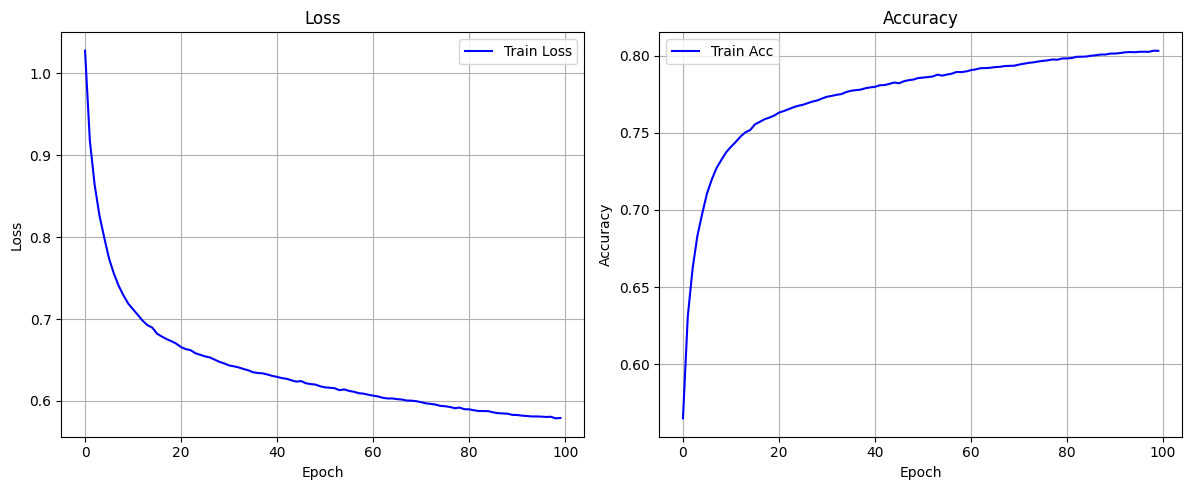

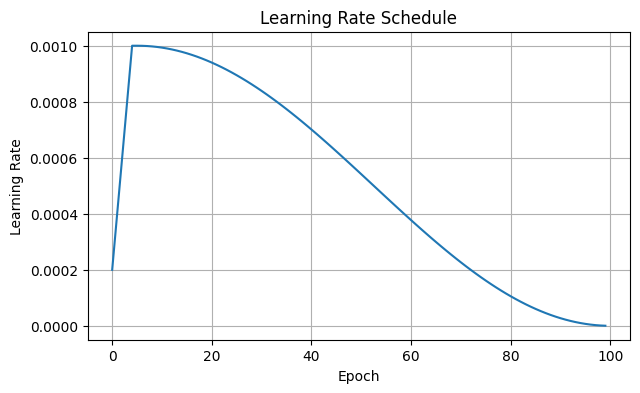

In [21]:
import matplotlib.pyplot as plt

def plot_training_summary(history, lr_fn, epochs):
    plt.figure(figsize=(18, 5))
    
    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.title('Accuracy')
    plt.plot(history.history.get('accuracy', []), label='Train Acc', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_learning_rate_schedule(lr_fn, epochs):
    lrs = [lr_fn(epoch) for epoch in range(epochs)]
    plt.figure(figsize=(7,4))
    plt.plot(range(epochs), lrs)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

# Usage:
plot_training_summary(history, lr_fn, total_epochs)
plot_learning_rate_schedule(lr_fn, total_epochs)

1/1 [==============================] - 0s 34ms/step


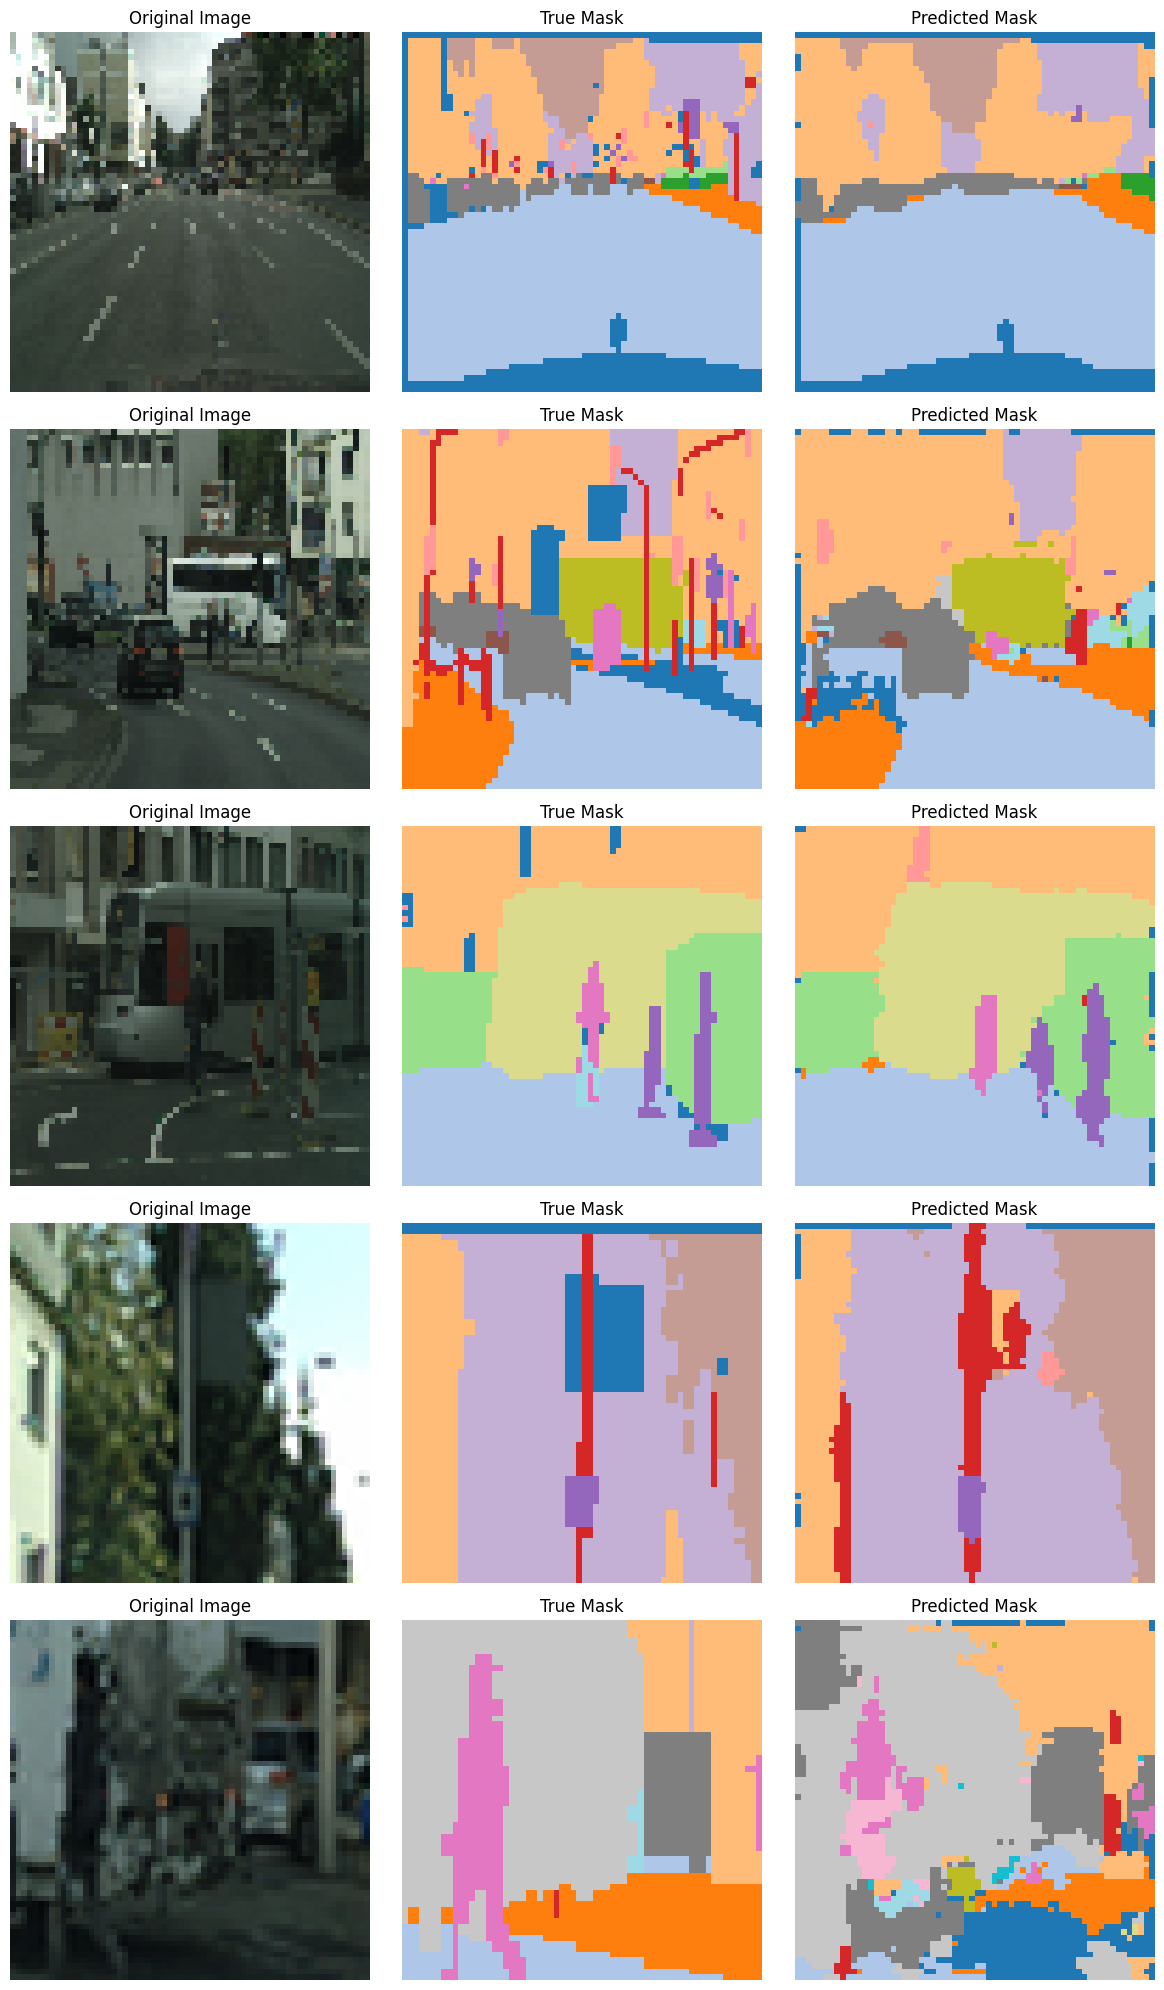

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Vuisualize predictions
def visualize_predictions(model, x_train, y_train, num_samples=5):
    indices = np.random.choice(len(x_train), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    
    for i, idx in enumerate(indices):
        img = x_train[idx]
        true_mask = y_train[idx]
        
        # Predict mask
        pred_logits = model.predict(np.expand_dims(img, axis=0))
        pred_mask = np.argmax(pred_logits, axis=-1)[0]
        
        # Plot original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        # Plot true mask
        axes[i, 1].imshow(true_mask, cmap='tab20', vmin=0, vmax=n_classes-1)
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis('off')
        
        # Plot predicted mask
        axes[i, 2].imshow(pred_mask, cmap='tab20', vmin=0, vmax=n_classes-1)
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, x_train, y_train, num_samples=5)

In [23]:
from sklearn.metrics import jaccard_score

model.evaluate(x_train, y_train, verbose=1)

# evaluate on mIoU (mean Intersection over Union)

# Predict on validation set
y_pred_logits = model.predict(x_train, verbose=0)
y_pred_classes = np.argmax(y_pred_logits, axis=-1)

# Flatten for sklearn
y_true_flat = y_train.flatten()
y_pred_flat = y_pred_classes.flatten()

# Compute mean IoU over all classes
miou = jaccard_score(y_true_flat, y_pred_flat, average='macro', labels=np.arange(n_classes), zero_division=0)
print(f"Final mIoU (sklearn): {miou:.4f}")

573/573 [==============================] - 159s 276ms/step - loss: 0.5291 - accuracy: 0.8138
Final mIoU (sklearn): 0.5481
